In [83]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv("issues.csv")

In [85]:
df.head()

,PROBLEM_TYPE,COUNT,AVG_CALLS_TO_RESOLVE,AVG_RESOLUTION_TIME,REOCCUR_RATE,REPLACEMENT_RATE
0,Admin Password Lost,45,2.3,54,0.15,0.00
1,Windows Reboots automatically,47,3.1,132,0.30,0.03
2,System not coming up after reboot,12,4.0,154,0.02,0.05
3,Slow system,165,1.2,32,0.03,0.00
4,Internet Connectivity loss,321,1.0,5,0.21,0.00


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
PROBLEM_TYPE            20 non-null object
COUNT                   20 non-null int64
AVG_CALLS_TO_RESOLVE    20 non-null float64
AVG_RESOLUTION_TIME     20 non-null int64
REOCCUR_RATE            20 non-null float64
REPLACEMENT_RATE        20 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 1.0+ KB


With a multidimensional dataset, we can reduce its dimension through PCA or TSNE to 2-D. That will make the modeleling faster and easy to visualize. However, since we just have 5 features here and they are all numeric, we can just use spatial distance to do the clustering.

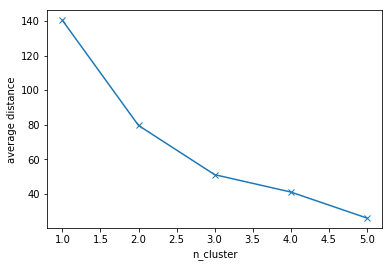

In [87]:
cluster_df = df.drop('PROBLEM_TYPE',axis = 1)
average_distance = []
for k in range(1,6):
    # initialize the model
    kmeans = KMeans(n_clusters = k)
    # fit and assign data to cluster
    kmeans.fit(cluster_df)
    pred = kmeans.predict(cluster_df)
    # take the average distance to centroids
    average_distance.append(sum(np.min(cdist(cluster_df, kmeans.cluster_centers_,'euclidean'),axis = 1))/pred.shape[0])

#visualize the objective value against different k value
plt.plot(range(1,6),average_distance,marker = 'x')
plt.xlabel('n_cluster')
plt.ylabel('average distance')
plt.show()

There are 2 "elbows" in the graph - and the decrease in the average distance slows down after n = 3. Let's try visualize the difference clustering the data into 3 groups.

In [88]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(cluster_df)
pred = kmeans.predict(cluster_df)
df['group'] =  pred

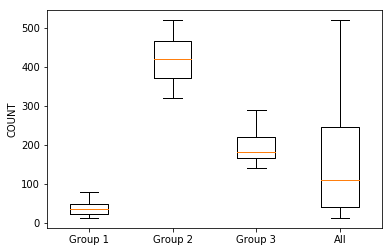

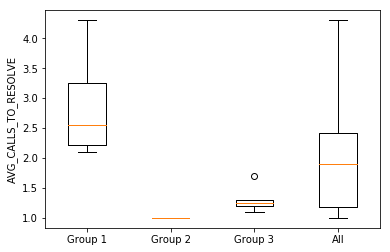

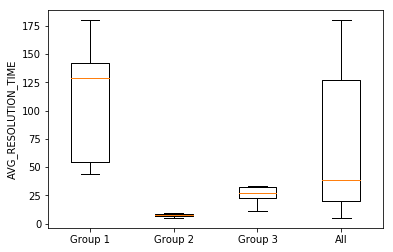

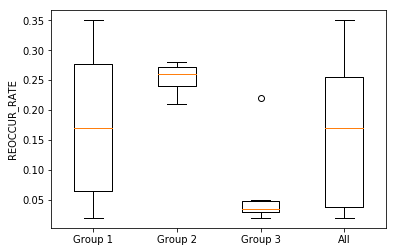

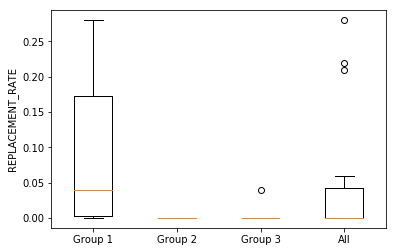

In [89]:
for feature in df.columns.drop(['PROBLEM_TYPE','group']):
    plt.boxplot([df[df['group'] == 0][feature],
                 df[df['group'] == 1][feature],
                 df[df['group'] == 2][feature],
                 df[feature]],labels = ('Group 1','Group 2','Group 3','All'))
    #plt.xlabel('Group')
    plt.ylabel(feature)
    plt.show()

By comparing across group and feature, we can see the three clusters are pretty different: 

Group 1 is for rare but time-consuming problems that sometimes need replacement. They occur the least often, take multiple calls and relatively more time to resolve, have a range of reoccur rate and replacement rate. 

Group 2 is for frequent, easy, re-occuring problems. They occur the most, take the least time or low number of calls to resolve, relatively more likely to reoccur, and low replacement rate.

Group 3 is the "middle-ground". They occur between 100 to 300 times, take relatively less time or low number of calls to resolve, less likely to reoccur, and low replacement rate except 1 outlier. 

Let's check the problem types in each group to see if our interpretations from the boxplots make common sense.

In [90]:
for i in range(0,3):
    print('**********Group',i+1,'problem type**********')
    types = np.sort(df[df['group'] == i]['PROBLEM_TYPE'].unique())
    print(*types, sep = "\n")
    print()

**********Group 1 problem type**********
Admin Password Lost
Cannot recover using restore
Dark areas on screen
Intermittent Blank Screen
Laptop loses charge very fast
Laptop not charging
Missing peripheral driver
New Installation hangs
System not coming up after reboot
Windows Reboots automatically

**********Group 2 problem type**********
Cannot detect keyboard
Cannot detect mouse
Head phone jack not working
Internet Connectivity loss

**********Group 3 problem type**********
Cannot find printer
DVD read error
Slow system
Too many popups in Browser
WIFI not functioning
anti-virus not working



From our analysis, there is a huge opportunity - we can automate the problem solving for Group 2 because it's taking very little time yet it's the most frequent. We can implement bot conversation flow or Q&A on the website to redirect complaints from agents to the automation. We also need to take a closer look on Group 1 and Group 2 to see if there's any hardware improvement we need to work on to reduce replacement and reoccuring rate.